In [2]:
#Can we get plots of first betas?
#Shows each individual plot along with which model best fits it
import pickle, math
import pandas as pd
import sqlite3
import random
import os
import itertools
exec(open('Imports.py').read()) #execfile('Imports.py')
exec(open('ImportModels.py').read())
import Modules.Funcs as funcs
# from Modules.Classes import Simulation
# from Modules.Classes import CopyTweak
# from Modules.Classes import CopyTweakRep
# from Modules.Classes import Packer
# from Modules.Classes import PackerRep
# from Modules.Classes import PackerEuc
# from Modules.Classes import ConjugateJK13
# from Modules.Classes import RepresentJK13
from scipy.stats import stats as ss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

#plotting options
STAT_LIMS =  (-1.0, 1.0)
#Fit to only last trial?
fitlast = False
#Make plots?
doplots = True
saveplots = False
if fitlast:
    showlast = True
else:
    showlast = False #True = Show last even if fitting to all?
#Bootstrap parameters
nbootstraps = 1000

#Some plotting options
font = {'family' : 'DejaVu Sans',
        'weight' : 'regular',
        'size'   : 15}

#Specify simulation values
N_SAMPLES = 10000
WT_THETA = 1.5
MIN_LL = 1e-10

# Specify default dataname
dbname = 'experiment-corner.db'#'experiments-5con.db'#raw data
dataname_def = '5con'#'5con'#bestparms comes from here

# Specify default dataname
# dataname_def = 'pooled'#'nosofsky1986'#'NGPMG1994'
participant_def = 'all'
unique_trials_def = 'all'
dataname = dataname_def
execfile('validate_data.py')

bestparmdb = "pickles/chtc_gs_best_params_{}".format(src)


plt.rc('font', **font)

# get data from pickle
with open(pickledir+src, "rb" ) as f:
    trials = pickle.load( f )

with open(bestparmdb, "rb" ) as f:
    best_params_t = pickle.load( f )

#Rebuild parms into a smaller dict
best_params = dict()
for modelname in best_params_t.keys():    
    best_params[modelname] = dict()
    for i,parmname in enumerate(best_params_t[modelname]['parmnames']):
        parmval = best_params_t[modelname]['bestparmsll']
        best_params[modelname][parmname] = parmval[i]
modelList = [Packer,RepresentJK13]
#modelList = [CopyTweak,CopyTweakRep,Packer, RepresentJK13,]                            

#Specify plot order
modelPlotOrder = np.array([[Packer,RepresentJK13],[CopyTweak,ConjugateJK13]])
     
unique_trials = 'all'
trials.task = task

#Create new trialset
con = sqlite3.connect(dbname)
participants = pd.read_sql_query("SELECT participant, condition from participants", con)
generation = pd.read_sql_query("SELECT * from generation", con)
alphas = pd.read_sql_query("SELECT * from alphas", con)
stimuli = pd.read_sql_query("SELECT * from stimuli", con).values
con.close()





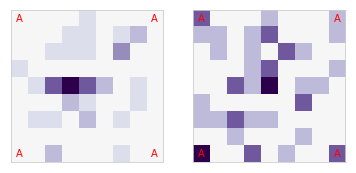

In [2]:
firsts = []
firsts += [generation.loc[(generation.wrap_ax==1.0) & (generation.trial==0),'stimulus']] #Circles
firsts += [generation.loc[(generation.wrap_ax!=1.0) & (generation.trial==0),'stimulus']] #Squares
#Convert to ps
ps = []
f,ax = plt.subplots(1,len(firsts),figsize=(3*len(firsts),3))
A = alphas.Corner_C.values
As = stimuli[A]
for i,first in enumerate(firsts):
    freq = first.value_counts(normalize=True,sort=False).sort_index()
    p = np.zeros(len(stimuli))
    p[freq.keys()] = freq.values
    ps += [p]
    gps = funcs.gradientroll(p,'roll')[:,:,0]
    ps_ElRange = gps.max()-gps.min();
    plotVals = (gps-gps.min())/ps_ElRange
    gammas = []
    funcs.plotgradient(ax[i], plotVals, As, [], gammas = gammas,clim = STAT_LIMS, cmap = 'PuOr',beta_col='green')

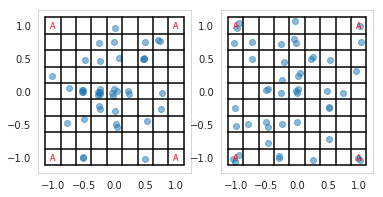

In [3]:
firsts = []
firsts += [generation.loc[(generation.wrap_ax==1.0) & (generation.trial==0),'stimulus']] #Circles
firsts += [generation.loc[(generation.wrap_ax!=1.0) & (generation.trial==0),'stimulus']] #Squares
#Convert to ps
ps = []
f,ax = plt.subplots(1,len(firsts),figsize=(3*len(firsts),3))
A = alphas.Corner_C.values
As = stimuli[A]
step = .25
adj = - step/2
for i,first in enumerate(firsts):
    stimvals = stimuli[first]
    #Add jitter
    stimvals = funcs.jitterize(stimvals,sd=.03)
    ax[i].scatter(stimvals[:,0],stimvals[:,1],alpha=.5)
    stepx = np.unique(stimuli[:,0]) + adj
    stepy = np.unique(stimuli[:,1]) + adj
    stepx = np.append(stepx,max(stepx)+step)
    stepy = np.append(stepy,max(stepy)+step)
    for pi,xx in enumerate(stepx):
        ax[i].grid(False)
        ax[i].plot([xx,xx],[min(stepy),max(stepy)],'k-')        
        ax[i].plot([min(stepx),max(stepx)],[xx,xx],'k-')
        for AsEl in As:
            ax[i].text(AsEl[0],AsEl[1],'A',color='red',
                       horizontalalignment='center',verticalalignment='center',
                      alpha=.15,
                      fontsize=8)


{'category_variance_bias': 1.0000000001078726, 'determinism': 2.452535524129651, 'category_mean_bias': 6.731660992152807, 'domain_variance_bias': 1.8971618173988867}
Outer edges: 0.03
Inner spaces: 0.04
0.008328839170985246
0.008328839170985246
0.0


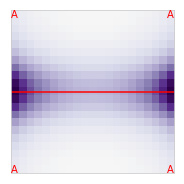

In [13]:
##Probabilities at outer edge vs inner space - Rep
steps = 21
vals = np.linspace(-1, 1,steps).tolist()
space = np.fliplr(funcs.cartesian([vals, vals]))
st = 2./(steps-1)

wrap_ax=1
outind = range(9) + [(e+1)*9 for e in range(7)] + [(e+1)*9+8 for e in range(7)] + range(72,81)
innind = [i for i in range(81) if not i in outind]
model = RepresentJK13
params = best_params[model.model]
# params['category_mean_bias']=0
categories1 = [np.array([[-1.,-1.],[1.,-1.],[-1.,1.],[1.,1.]])]

# categories1 = [np.array([[-1,-1],[1,-1],[-1,1],[1,1]])]

# categories1 = [np.array([[-1,-.5],[1,-.5],[-1,-.75],[1,-.75]])]
temp1 = model(categories1,params,wrap_ax=wrap_ax,stimstep=[st,st]).get_generation_ps(space,1,'generate')
outps = sum(temp1[outind])
innps = sum(temp1[innind])
# print(np.round(np.reshape(temp1,(9,9)),3))
print(params)
print('Outer edges: ' + str(np.round(outps,2)))
print('Inner spaces: ' + str(np.round(innps,2)))
temp11= np.reshape(temp1,(steps,steps))
midtemp = (steps+1)/2 - 1
oneup = temp11[midtemp+1][0]
onedn = temp11[midtemp-1][0]
print(oneup)
print(onedn)
print(oneup-onedn)
f,ax = plt.subplots(1,1,figsize=(3,3))
gps = funcs.gradientroll(temp1,'roll')[:,:,0]
ps_ElRange = gps.max()-gps.min();
plotVals = (gps-gps.min())/ps_ElRange
gammas = []
funcs.plotgradient(ax, plotVals, categories1[0], [], gammas = gammas,clim = STAT_LIMS, cmap = 'PuOr',beta_col='green')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
yhalf = np.mean(ylim)
ax.plot(xlim,[yhalf,yhalf],'r-')

In [23]:
np.unique([3,4,1,4,2])

array([1, 2, 3, 4])

In [22]:
np.unique(stimuli[:,0])

array([-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ])

Outer edges: 0.25
Inner spaces: 0.75


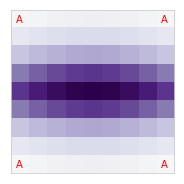

In [13]:
# Probabilities at outer edge vs inner space - Rep
wrap_ax=1
outind = range(9) + [(e+1)*9 for e in range(7)] + [(e+1)*9+8 for e in range(7)] + range(72,81)
innind = [i for i in range(81) if not i in outind]
model = Packer
params = best_params[model.model]
categories1 = [np.array([[-1.,-1.],[1.,-1.],[-1.,1.],[1.,1.]])]
temp1 = model(categories1,params,wrap_ax=wrap_ax).get_generation_ps(stimuli,1,'generate')
outps = sum(temp1[outind])
innps = sum(temp1[innind])
# print(np.round(np.reshape(temp1,(9,9)),3))

print('Outer edges: ' + str(np.round(outps,2)))
print('Inner spaces: ' + str(np.round(innps,2)))
f,ax = plt.subplots(1,1,figsize=(3,3))
gps = funcs.gradientroll(temp1,'roll')[:,:,0]
ps_ElRange = gps.max()-gps.min();
plotVals = (gps-gps.min())/ps_ElRange
gammas = []
funcs.plotgradient(ax, plotVals, categories1[0], [], gammas = gammas,clim = STAT_LIMS, cmap = 'PuOr',beta_col='green')

In [10]:
categories1[0]

array([[-1, -1],
       [ 1, -1],
       [-1,  1],
       [ 1,  1]])